In [2]:
import os
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import numpy as np
from iminuit import minuit
from iminuit.cost import LeastSquares
import pandas as pd
from scipy import constants

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C:\Users\ricca\AppData\Local\Temp\ipykernel_14664\4233083143.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
parent = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\IR_KIDS_CHAR\2o raff\RES_DATA'

In [7]:
data = pd.read_csv(parent+r'\RES1.txt', sep='\t')

In [8]:
def resonance_model(f, pars):
    x = (f-pars[3])/pars[3]
    return 1-(pars[0]/pars[1])*(np.exp(1j*pars[2])/(1+1j*2*x*pars[0]))

polyorder = 2

def model(x, *pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return pol*np.abs(res)

def phase(x,*pars):
    pol = np.polyval(pars[:polyorder+1], x)
    res = resonance_model(x, pars[polyorder+1:])
    return np.unwrap(np.angle(1j*res.imag+res.real+pol))

In [46]:
F = data['F']
I = data['I']
Q = data['Q']

In [50]:
print((max(F)-min(F))/2*1e-6)

4.497189256714821


In [10]:
F = np.array(F)
C = np.array(Q)+1j*np.array(I)
A = np.abs(C)
P = np.unwrap(np.angle(C))

Text(0, 0.5, '$\\phi$ [rad]')

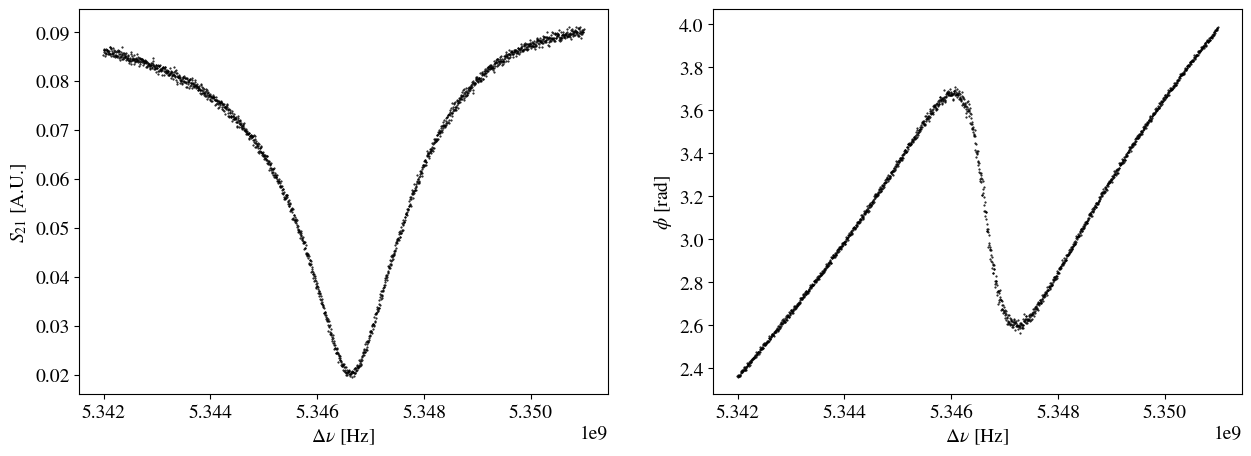

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')

In [12]:
A = 20*np.log10(A)
#F = (F - F[np.argmin(A)])/F[np.argmin(A)]
a = np.polyfit(F[:100],P[:100],1)
P = P - np.polyval(a,F)
len_fit = int(np.floor(len(A)/10))
pol_amp = np.polyfit(F[:len_fit], A[:len_fit], 2)
A_rms = np.sqrt(np.mean((np.polyval(pol_amp, F[:len_fit])-A[:len_fit])**2))   

In [13]:
pol_ph = np.polyfit(F[:len_fit], P[:len_fit], 2)
P_rms = np.sqrt(np.mean((np.polyval(pol_ph, F[:len_fit])-P[:len_fit])**2))

In [37]:
p0 = [1e-20,1e-9,-31,12e3,18e3,3.2,5.3467*1e9]

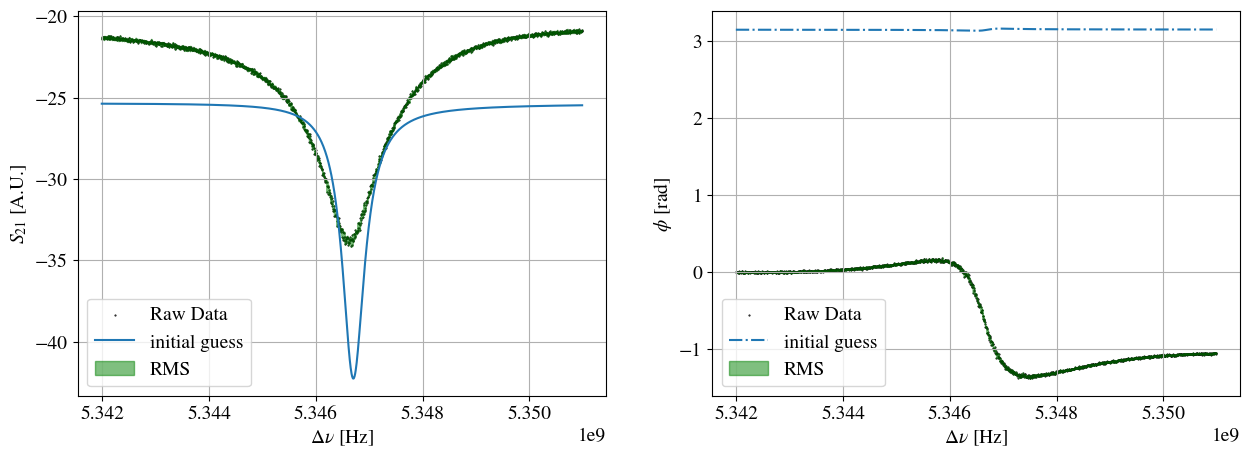

In [38]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F,model(F,*p0), label='initial guess')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].plot(F,phase(F,*p0),linestyle='-.', label='initial guess')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

In [39]:
lsq = LeastSquares(F,A,A_rms*np.ones(len(A)),model)
m= minuit.Minuit(lsq, *p0)
m.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.869e+04 (χ²/ndof = 11.7) │              Nfcn = 335              │
│ EDM = 1.14e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │62.795e-21 │ 0.005e-21 │            │            │         │         │       │
│ 1 │ x1   │1.2821919e-9│0.0000012e-9│            │            │         │         │       │
│ 2 │ x2   │-29.491679 │ 0.000006  │            │            │         │         │       │
│ 3 │ x3   │ 3.72194e3 │ 0.00007e3 │            │            │         │         │       │
│ 4 │ x4   │ 6.17340e3 │ 0.00019e3 │            │            │         │         │       │
│ 5 │ x5   │ 3.046000  │ 0.000004  │            │            │         │         │       │
│ 6 │ x6   │5.3466687197e9│0.0000000018e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                              x0                              x1                              x2                              x3                              x4                              x5                              x6 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                        2.43e-47                   -7.214498e-42         -38.571764105269473e-33  -350.798327904867221604945e-27   934.272343348975596200034e-27      -14.190644840810886507e-30 -1.756486921434923242912873e-24 │
│ x1 │                   -7.214498e-42                        1.39e-30                   -210.2408e-27              104.0706705699e-21             -277.1688039956e-21                   4.2098223e-24              521.0797169032e-21 │
│ x2 │         -38.571764105269473e-33                   -210.2408e-27                        3.97e-11                         0.56e-9                        -1.48e-9                               0                         2.79e-9 │
│ x3 │  -350.798327904867221604945e-27              104.0706705699e-21                         0.56e-9                         0.00512                          -0.013                      204.514e-9                           0.025 │
│ x4 │   934.272343348975596200034e-27             -277.1688039956e-21                        -1.48e-9                          -0.013                          0.0359                     -544.677e-9                           -0.07 │
│ x5 │      -14.190644840810886507e-30                   4.2098223e-24                               0                      204.514e-9                     -544.677e-9                         1.3e-11                 

In [41]:
lsqp = LeastSquares(F,P,P_rms*np.ones(len(P)),phase)
mp = minuit.Minuit(lsqp, *m.values)
mp.migrad(ncall=10000, iterate=1000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.059e+06 (χ²/ndof = 664.4)│             Nfcn = 10006             │
│ EDM = 0.103 (Goal: 0.0002)       │            time = 4.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           ABOVE call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 21.9e-18  │  0.4e-18  │            │            │         │         │       │
│ 1 │ x1   │ 122.2e-9  │  2.2e-9   │            │            │         │         │       │
│ 2 │ x2   │    659    │    13     │            │            │         │         │       │
│ 3 │ x3   │ 3.2510e3  │ 0.0023e3  │            │            │         │         │       │
│ 4 │ x4   │   0.465   │   0.009   │            │            │         │         │       │
│ 5 │ x5   │  2.19919  │  0.00031  │            │            │         │         │       │
│ 6 │ x6   │5.3468093e9│0.0000005e9│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │                         x0                         x1                         x2                         x3                         x4                         x5                         x6 │
├────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │                   1.52e-37           870.26761167e-30 4.95441983567791055521e-18     882.09232072387681e-24   -3.34260937006713421e-21      -4.28086054986931e-24 5.80549383579586830706e-18 │
│ x1 │           870.26761167e-30                   4.98e-18            28.334856901e-9               5.041625e-12             -19.116741e-12                -24.482e-15            33.201872037e-9 │
│ x2 │ 4.95441983567791055521e-18            28.334856901e-9                        161                          0                 -108.83e-3                 -139.38e-6                     0.19e3 │
│ x3 │     882.09232072387681e-24               5.041625e-12                          0                       5.16                    0.20e-3                  140.14e-6                       -134 │
│ x4 │   -3.34260937006713421e-21             -19.116741e-12                 -108.83e-3                    0.20e-3                   7.35e-05                    0.07e-6                 -100.92e-3 │
│ x5 │      -4.28086054986931e-24                -24.482e-15                 -139.38e-6                  140.14e-6                    0.07e-6                   9.88e-08               -79.57289e-3 │
│ x6 │ 5.80549383579586830706e-18            33.201872037e-9                     0.19e3                       -134                 -100.92e-3               -79.57289e-3                    2.1e+05 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────

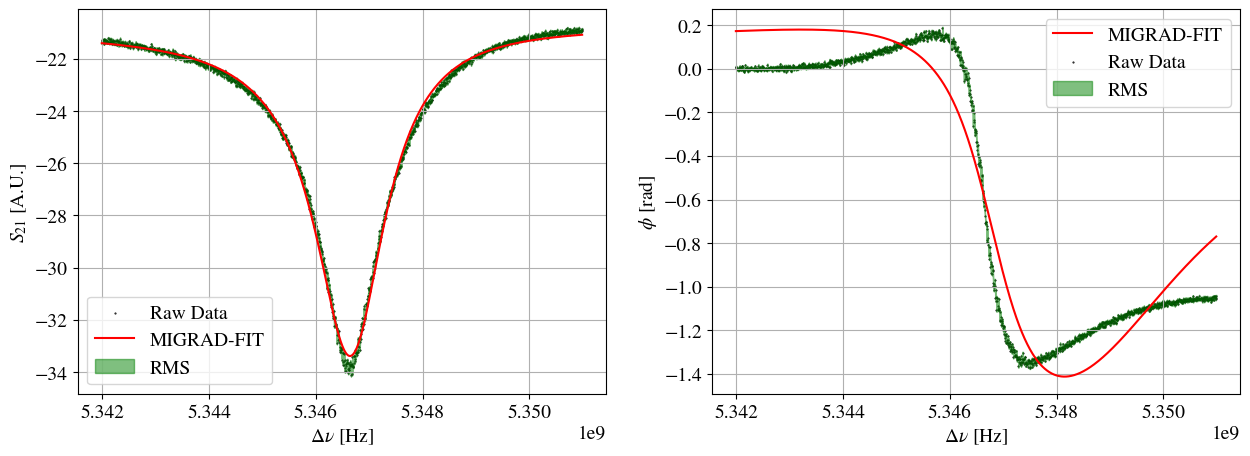

In [42]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs[0].plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs[1].plot(F, phase(F,*mp.values), color='red',label='MIGRAD-FIT')
axs[0].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[0].set_ylabel(r'$S_{21}$ [A.U.]')
axs[1].scatter(F,P,s=1,marker='.',color='black', label='Raw Data')
axs[1].set_xlabel(r'$\Delta \nu$ [Hz]')
axs[1].set_ylabel(r'$\phi$ [rad]')
axs[0].fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
axs[1].fill_between(F, P+P_rms, P-P_rms, alpha=0.5, color='green',label='RMS')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

Text(5342000000.0, -30, '$\\chi^{2}_{0} = $11.73')

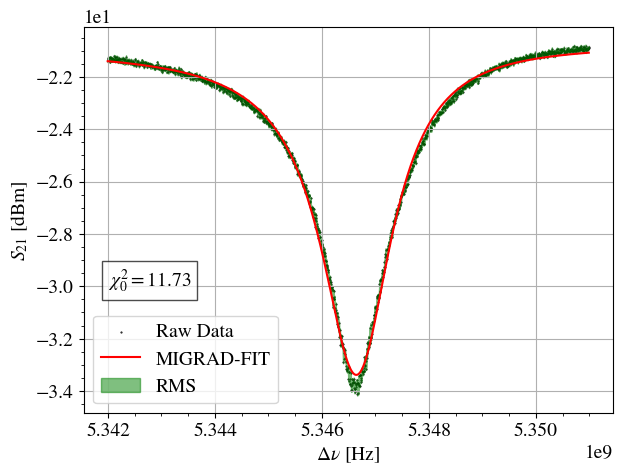

In [53]:
fig, axs = plt.subplots(1,1)
axs.scatter(F,A,s=1,marker='.',color='black', label='Raw Data')
axs.plot(F, model(F,*m.values), color='red',label='MIGRAD-FIT')
axs.set_xlabel(r'$\Delta \nu$ [Hz]')
axs.set_ylabel(r'$S_{21}$ [dBm]')
axs.fill_between(F, A+A_rms, A-A_rms, alpha=0.5, color='green',label='RMS')
fig.tight_layout()
# Optionally add minor ticks and scientific notation
axs.legend()
axs.minorticks_on()
axs.grid()
axs.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# Place the combined text with a bounding box
axs.text(5.342*1e9,-30,r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}",
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))


In [43]:
print('Q(S21) = ', m.values[3])
print('Q(phase) = ', mp.values[3])
print('Q_c(S21) = ', m.values[4])
print('Q_c(phase) = ', mp.values[4])

Q(S21) =  3721.936759164357
Q(phase) =  3251.0190624152424
Q_c(S21) =  6173.403764236766
Q_c(phase) =  0.4646511225507572


In [44]:
Qi = (m.values[3]**(-1)+m.values[4]**(-1))**(-1)
print('Qi(S21) = ',Qi)

Qi(S21) =  2322.0038102720096


In [45]:
idx = [i for i,x in enumerate(F) if x>5.3463*1e9 and x<5.3469*1e9]
f = F[idx]
a = A[idx]

In [59]:
vals = np.polyfit(f,a,2)

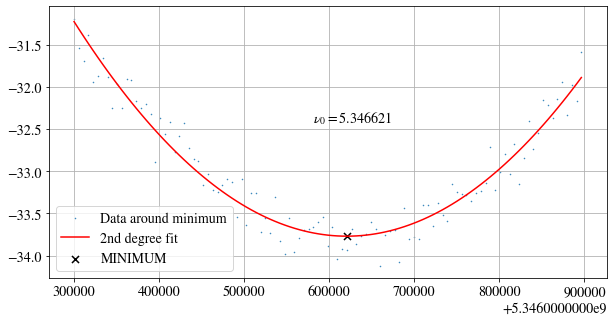

In [79]:
plt.figure(figsize=(10,5))
plt.scatter(f,a,marker='.',s=1, label='Data around minimum')
plt.plot(f,np.polyval(vals,f),color='red',label='2nd degree fit')
plt.scatter(-vals[1]/(2*vals[0]),-(vals[1]**2-4*vals[0]*vals[2])/(4*vals[0]),marker='x',s=50,color='black',label='MINIMUM')
plt.legend()
plt.text(f[50],a[20],r'$\nu_{0} = $'+"{:.6f}".format((-vals[1]/(2*vals[0])*1e-9)))
plt.grid()